# Label Transfer of Healthy Control cell compartments via Haber 2020 to spatial dataset
- Created by: Christian Eger
- Creation date: October 7, 2024
- environment: cellpymc_environment.yml

## Import modules

In [1]:
from pathlib import Path
import squidpy as sq
import torch
import scanpy as sc
import cell2location
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math

## Notebook Control Flow

In [2]:
rerun_reference: bool= True

In [2]:
adata = sc.read_h5ad("/mnt/LaCIE/ceger/Projects/COPD/COPD_influenza/10-Mapping_to_spatial_dataset/.data/results/COPD_to_Spatial/reference_signatures/2024-11-07_12-22-26_reference.h5ad")
adata

AnnData object with n_obs × n_vars = 45802 × 17876
    obs: 'batch', 'celltype', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'n_cells', 'nonz_mean'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'mod'
    obsm: 'X_umap'
    varm: 'means_per_cluster_mu_fg', 'q05_per_cluster_mu_fg', 'q95_per_cluster_mu_fg', 'stds_per_cluster_mu_fg'

In [3]:
adata.obs

,batch,celltype,_indices,_scvi_batch,_scvi_labels
9177992-GER14_CRTL-V3,GER14_CRTL,Ciliated,0,2,2
594856-GER14_CRTL-V3,GER14_CRTL,Deuterosomal,1,2,4
8134752-GER14_CRTL-V3,GER14_CRTL,Ciliated,2,2,2
8729561-GER14_CRTL-V3,GER14_CRTL,Ciliated,3,2,2
9297458-GER14_CRTL-V3,GER14_CRTL,Deuterosomal,4,2,4
...,...,...,...,...,...
HD68_TTATGCTTCTTGACGA,VUHD68,Smooth Muscle Cells,45797,12,23
HD68_TTGGCAAAGAAGGACA,VUHD68,Smooth Muscle Cells,45798,12,23
HD68_TTTATGCTCACGACTA,VUHD68,Smooth Muscle Cells,45799,12,23
HD70_CACCACTCAGACGTAG,VUHD70,Smooth Muscle Cells,45800,14,23


In [4]:
mod = cell2location.models.RegressionModel.load("/mnt/LaCIE/ceger/Projects/COPD/COPD_influenza/10-Mapping_to_spatial_dataset/.data/results/COPD_to_Spatial/reference_signatures", adata)
mod

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File                                                                                                      
         /mnt/LaCIE/ceger/Projects/COPD/COPD_influenza/10-Mapping_to_spatial_dataset/.data/results/COPD_to_Spatial/
         reference_signatures/model.pt already downloaded                                                          


/home/ceger/miniforge3/envs/cellpymc/lib/python3.10/site-packages/scvi/model/base/_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_pa

Training:   0%|          | 0/437 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


RegressionBackgroundDetectionTech model with the following params: 
n_factors: 28 
n_batch: 16 
Training status: Trained

## Set Device

In [3]:
if torch.cuda.is_available():
    print(f"Number of available CUDA devices: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No CUDA devices available")

Number of available CUDA devices: 2
Device 0: NVIDIA RTX 6000 Ada Generation
Device 1: NVIDIA RTX 6000 Ada Generation


## Data Prep

### Folder Structure

In [4]:
global_repo_data = Path.cwd() / '..' / '.data'
local_folder_data = Path.cwd() / '.data'
figures_dir = Path.cwd() / 'figures'
figures_dir.mkdir(exist_ok=True)
results_folder = local_folder_data / 'results' / 'COPD_to_Spatial' 
ref_run_name = results_folder / 'reference_signatures'
run_name = results_folder / 'cell2location_map'

### Reference Dataset

#### Concatenating Reference Datasets

In [5]:
'''
Labelled reference dataset for epithelial cells (Our COPD Dataset)
Only Healthy Control Group 
'''
if rerun_reference:
    cell_label = "cell_compartment"
    adata_copd = sc.read_h5ad(global_repo_data / 'Marburg_cell_states_locked_ctl240709.raw.h5ad')
    adata_copd = adata_copd[adata_copd.obs['group'] == 'healthy_ctrl'].copy()
    adata_copd.obs["celltype"] = adata_copd.obs[cell_label]
    adata_copd

In [6]:
'''
Labelled reference dataset for other cell types (Habermann 2020 )
Only Control Group
'''
if rerun_reference:
    adata_habermann = sc.read_h5ad(local_folder_data / 'GSE135893_ILD_annotated_fullsize.h5ad')
    adata_habermann = adata_habermann[adata_habermann.obs['Diagnosis'] == "Control"].copy()
    adata_habermann.obs["batch"] = adata_habermann.obs["Sample_Name"]
    habermann_n_obs = adata_habermann.n_obs
    adata_habermann

In [7]:
'''
Preparing habermann dataset for concatenation by removing epithelial celltypes (chosen from adata_haberman.obs['celltypes'])
'''
if rerun_reference:
    epithelial_cell_types = [
        'Basal', 'Ciliated', 'Differentiating Ciliated', 'SCGB3A2+',
        'SCGB3A2+ SCGB1A1+',  'MUC5AC+ High', 'MUC5B+', 'AT1',
        'AT2', 'Proliferating Epithelial Cells', 'Transitional AT2', 'KRT5-/KRT17+',
    ]
    adata_habermann = adata_habermann[~adata_habermann.obs["celltype"].isin(epithelial_cell_types)]
    habermann_n_obs -= adata_habermann.n_obs
    print(f"removed {habermann_n_obs} epithelial cells")
    adata_habermann

removed 8430 epithelial cells


In [8]:
if rerun_reference:
    adata_reference = sc.concat([adata_copd, adata_habermann])
    adata_reference

#### Gene Filtering

/home/ceger/miniforge3/envs/cellpymc/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


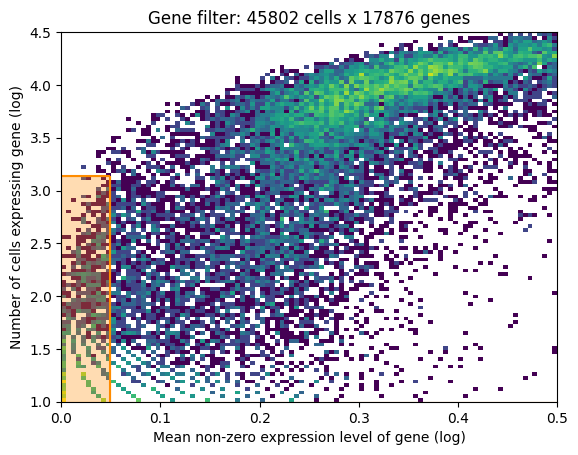

In [9]:
if rerun_reference:
    selected = cell2location.utils.filtering.filter_genes(adata_reference, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
    adata_reference = adata_reference[:, selected].copy()
    adata_reference

#### Model Training

In [10]:
if rerun_reference:
    cell2location.models.RegressionModel.setup_anndata(adata=adata_reference,
                            batch_key="batch",
                            labels_key="celltype",
                           )

In [11]:
if rerun_reference:
    mod = cell2location.models.RegressionModel(
        adata_reference,
    )
    mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.2.0.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'batch',
│   'labels_key': 'celltype',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  16   │
│         n_cells          │ 45802 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  28   │
│          n_vars          │ 17876 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃  Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │  GER02_CTRL   │          0          │
│                    │  GER12_CTRL   │          1          │
│                    │  GER14_CRTL   │          2          │
│                    │  GnR08_CTRL   │          3          │
│                    │  GnR_07_CTRL  │          4          │
│                    │ ST08_GnR_CTRL │          5          │
│                    │    THD0001    │          6          │
│                    │    THD0002    │          7          │
│                    │    THD0005    │          8          │
│                    │    VUHD65     │          9          │
│                    │    VUHD66     │         10          │
│                    │    VUHD67     │         11          │
│                    │    VUHD68     │         12          │
│                    │    VUHD69     │         13          │
│                    │    VUHD70     │         14          │
│                    │    VUHD71     │         15          │
└────────────────────┴───────────────┴─────────────────────┘

                            labels State Registry                            
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃         Categories          ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['celltype'] │           B Cells           │          0          │
│                       │            Basal            │          1          │
│                       │          Ciliated           │          2          │
│                       │            Club             │          3          │
│                       │        Deuterosomal         │          4          │
│                       │      Endothelial Cells      │          5          │
│                       │             Epi             │          6          │
│                       │         Fibroblasts         │          7          │
│                       │           Goblet            │          8          │
│                       │          Ionocyte           │          9          │
│                       │ Lymphatic Endothelial Cells │         10          │
│                       │         Macrophages         │         11          │
│                       │         Mast Cells          │         12          │
│                       │      Mesothelial Cells      │         13          │
│                       │            Mixed            │         14          │
│                       │          Monocytes          │         15          │
│                       │       Myofibroblasts        │         16          │
│                       │          NK Cells           │         17          │
│                       │     PLIN2+ Fibroblasts      │         18          │
│                       │        Plasma Cells         │         19          │
│                       │  Proliferating Macrophages  │         20          │
│                       │    Proliferating T Cells    │         21          │
│                       │          Secretory          │         22          │
│                       │     Smooth Muscle Cells     │         23          │
│                       │           SupraB            │         24          │
│                       │           T Cells           │         25          │
│                       │            cDCs             │         26          │
│                       │            pDCs             │         27          │
└───────────────────────┴─────────────────────────────┴─────────────────────┘

In [12]:
if rerun_reference:
    mod.train(max_epochs=250)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ceger/miniforge3/envs/cellpymc/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBL

Training:   0%|          | 0/250 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=250` reached.


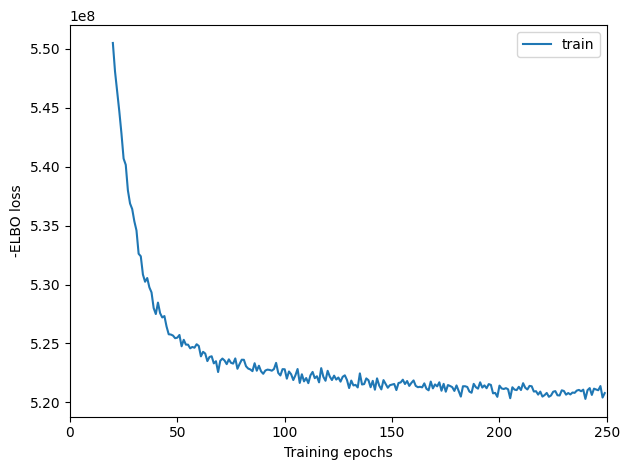

In [13]:
if rerun_reference:
    mod.plot_history(20)

In [14]:
if rerun_reference:
    # In this section, we export the estimated cell abundance (summary of the posterior distribution).
    adata_reference = mod.export_posterior(
        adata_reference, sample_kwargs={'num_samples': 1000, 'batch_size': 2500}
    )
    
    # Save model
    mod.save(ref_run_name, overwrite=True)
    
    # Save anndata object with results
    adata_file = ref_run_name / 'sc.h5ad'
    adata_reference.write(adata_file)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Sampling local variables, batch:   0%|          | 0/19 [00:00<?, ?it/s]

Sampling global variables, sample:   0%|          | 0/999 [00:00<?, ?it/s]

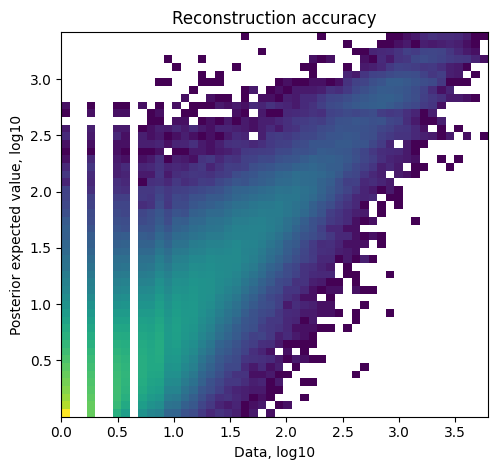

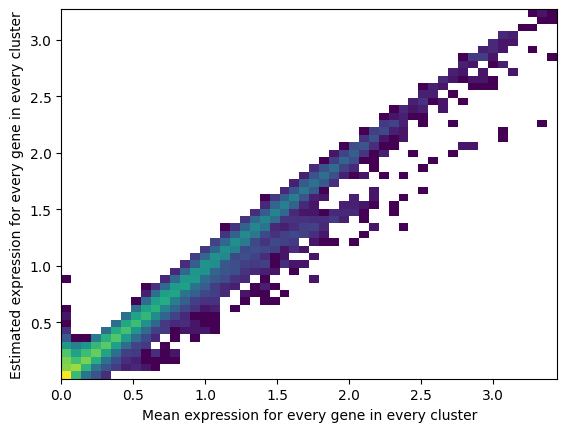

In [15]:
mod.plot_QC()

In [16]:
if not rerun_reference:
    adata_file = max(ref_run_name.glob("*.h5ad"), key=lambda f: f.stem.split('_reference')[0])
    adata_reference = sc.read_h5ad(adata_file)
    mod = cell2location.models.RegressionModel.load(ref_run_name, adata_reference)

In [17]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_reference.varm.keys():
    inf_aver = adata_reference.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_reference.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_reference.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_reference.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_reference.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,B Cells,Basal,Ciliated,Club,Deuterosomal
A1BG,0.253588,0.039968,0.073979,0.003453,0.023247
A1BG-AS1,0.031980,0.033608,0.241899,0.009011,0.074451
A2M,0.079365,0.002330,0.001145,0.002078,0.007482
A2M-AS1,0.020937,0.002649,0.019064,0.009604,0.011481
A2ML1,0.024165,0.006050,0.007187,0.067909,0.040209


### Query Dataset

In [18]:
'''Unlabelled query dataset'''
adata_spatial = sc.read_h5ad(local_folder_data / 'Franzen_L_2024_human.h5ad')
filtered_columns = list(adata_spatial.obs.columns[~adata_spatial.obs.columns.str.startswith("c2l")])
adata_spatial.obs = adata_spatial.obs[filtered_columns]
adata_spatial.obs['batch'] = adata_spatial.obs['sample_id']
sample = 'V10T31-051-D1' 
adata_spatial_sample = adata_spatial[adata_spatial.obs['batch'] == sample].copy()
adata_spatial_sample

AnnData object with n_obs × n_vars = 4488 × 27260
    obs: 'in_tissue', 'array_row', 'array_col', 'orig.ident', 'sample_name_x', 'sample_id', 'slide_id_x', 'slide_ca_x', 'condition_x', 'subject_alias_x', 'species_x', 'tissue_x', 'subject_gender_x', 'tissue_alias_x', 'B_tissue_selection_x', 'fibrotic_extent_score_by_pathologist_0.3', 'replicate_x', 'annotation', 'annotation_FF', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'percent.mt', 'percent.hb', 'percent.rp', 'percent.chrY', 'factor_14_cutoff', 'f14_subclusters', 'f14_c0_nbs_clusters', 'd_c0', 'r_dist_F14_C0', 'sample_name_y', 'slide_id_y', 'slide_ca_y', 'condition_y', 'subject_alias_y', 'tissue_alias_y', 'B_tissue_selection_y', 'fibrotic_extent_score_by_pathologist_0-3', 'replicate_y', 'species_y', 'tissue_y', 'subject_gender_y', 'n_counts', 'batch'
    var: 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

## Spatial Mapping

In [46]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_spatial_sample.var_names, inf_aver.index)
adata_spatial_sample = adata_spatial_sample[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_spatial_sample)

In [47]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_spatial_sample, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.2.0.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 4488  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 17168 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [48]:
mod.train(max_epochs=30000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ceger/miniforge3/envs/cellpymc/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/ceger/miniforge3/envs/cellpymc/lib/python3.10/site-packages/lightnin

Training:   0%|          | 0/30000 [00:00<?, ?it/s]

In [ ]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_spatial_sample = mod.export_posterior(
    adata_spatial_sample, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs}
)

# Save model
mod.save(run_name, overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_spatial)

# Save anndata object with results
adata_file = run_name / f"{sample}.h5ad"
adata_spatial_sample.write(adata_file)
adata_file



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Sampling local variables, batch:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling global variables, sample:   0%|          | 0/999 [00:00<?, ?it/s]

PosixPath('/mnt/LaCIE/ceger/Projects/COPD/COPD_influenza/10-Mapping_to_spatial_dataset/.data/results/lymph_nodes_analysis/cell2location_map/sp.h5ad')

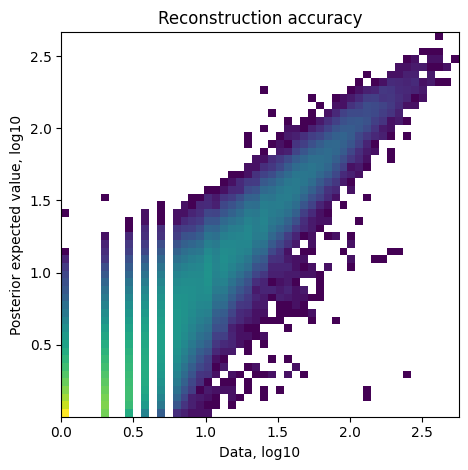

In [ ]:
mod.plot_QC()

In [ ]:
adata_spatial_sample.obs[adata_spatial_sample.uns['mod']['factor_names']] = adata_spatial_sample.obsm['q05_cell_abundance_w_sf']

In [ ]:
adata_spatial_sample.obs["sample"] = adata_spatial_sample.obs["batch"]
slide = cell2location.utils.select_slide(adata_spatial, 'V10T31-051-D1')

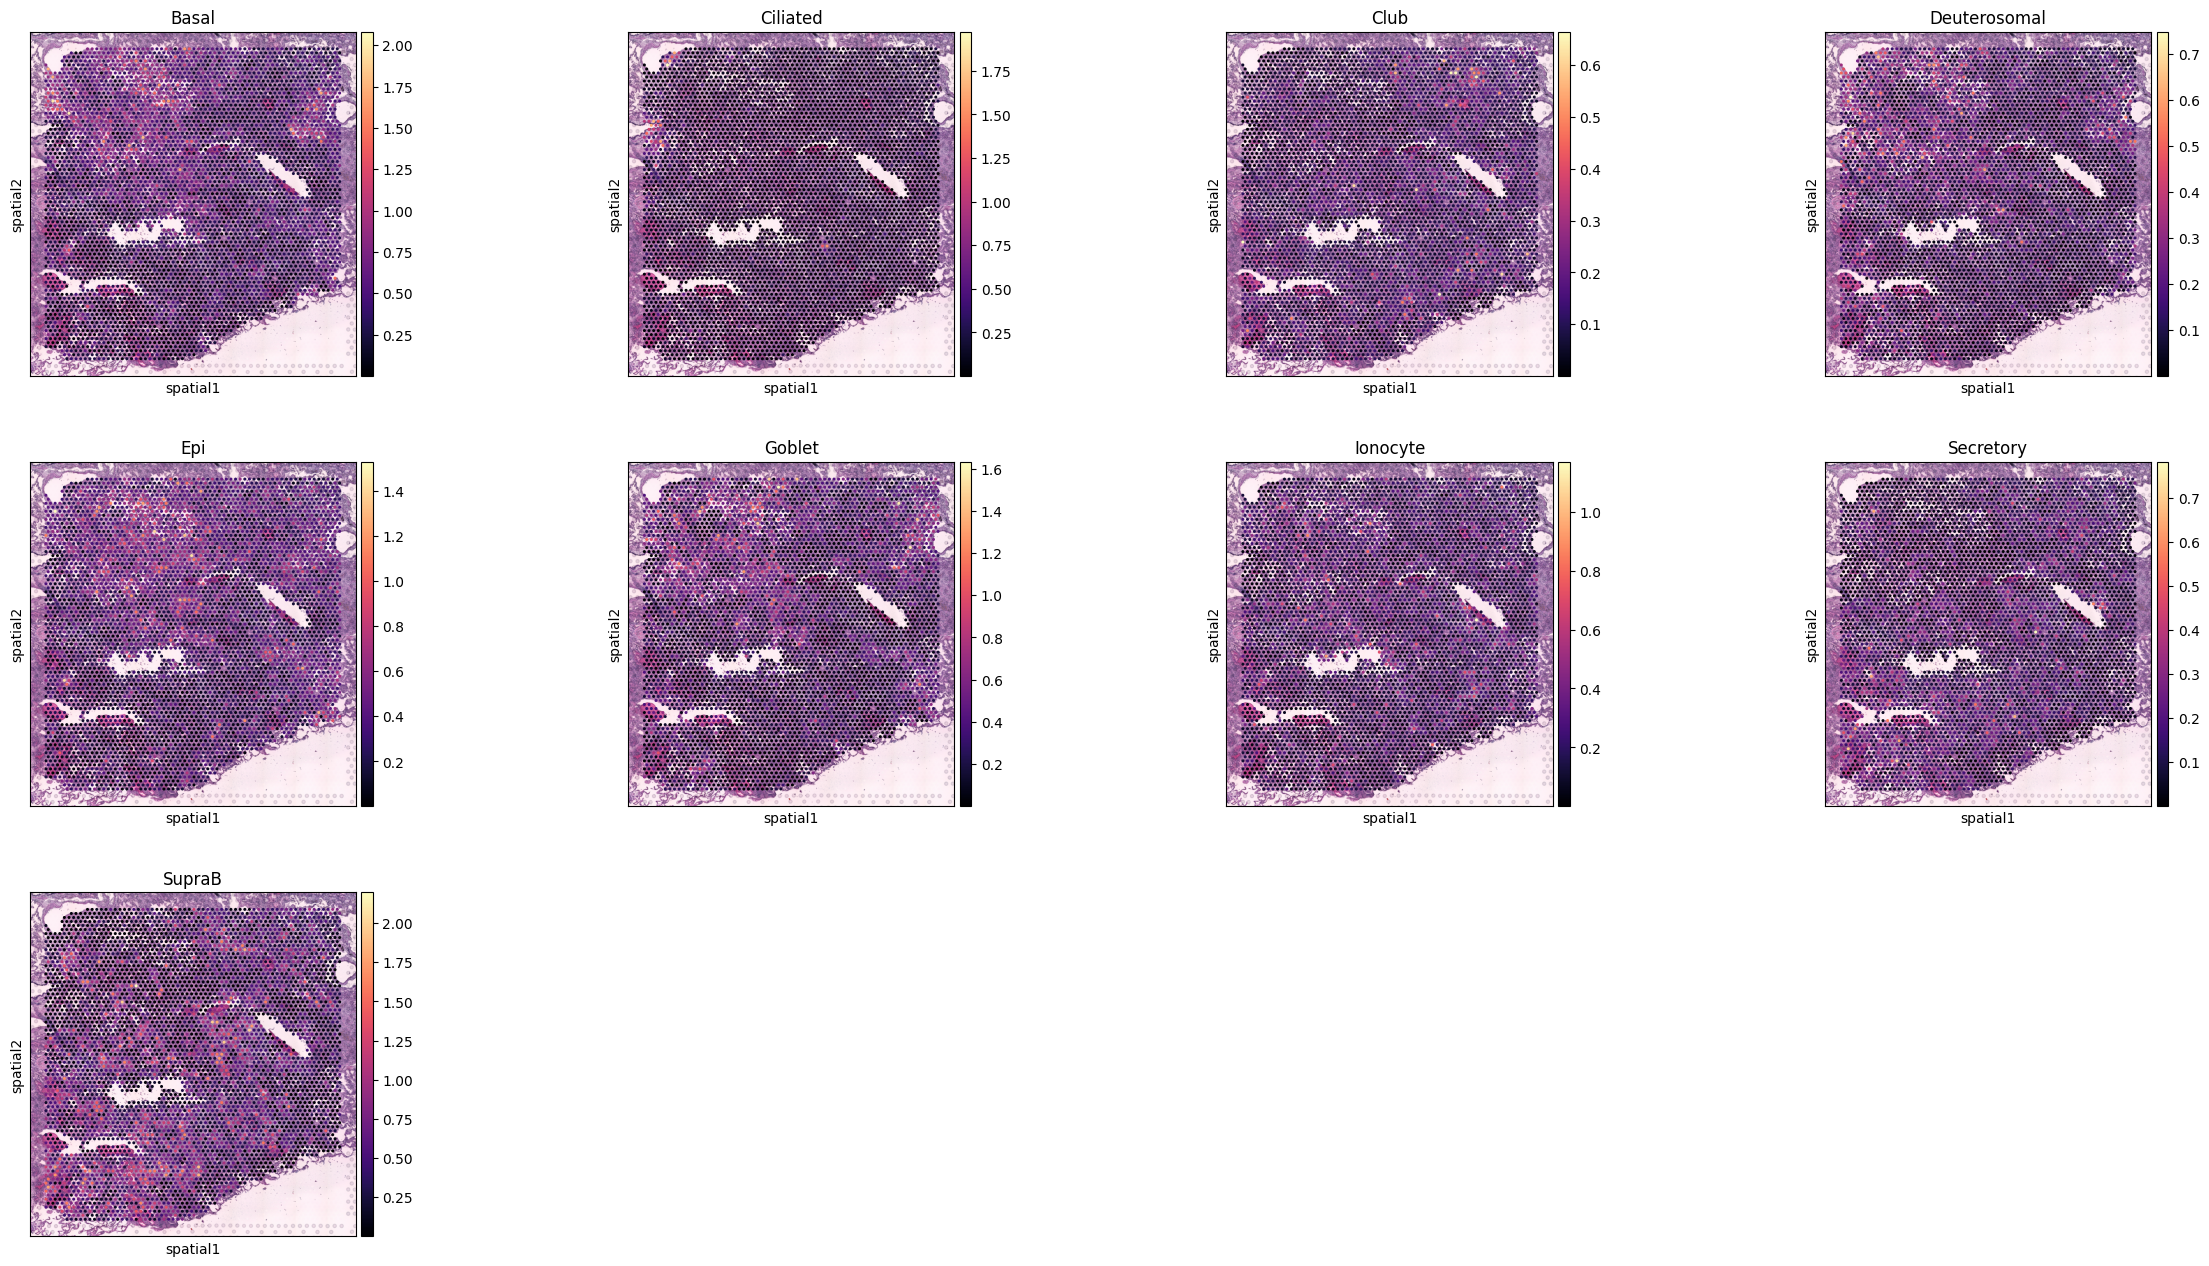

In [ ]:
sc.pl.spatial(
    slide, 
    color=[
        "Basal", "Ciliated", "Club",
        "Deuterosomal", "Epi", "Goblet",
        "Ionocyte", "Secretory", "SupraB"
    ],
    cmap="magma"
)